# 주가 데이터 다운로드하기

In [9]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

tickers=['TSLA','NVDA']

# 기간 지정
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-12-31', '%Y-%m-%d')


result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 포맷 변경
    df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
    # 칼럼 이름 변경
    df.columns = [ticker]

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,NVDA
Date,,
2024-01-02,248.419998,48.143856
2024-01-03,238.449997,47.545158
2024-01-04,237.929993,47.973946
2024-01-05,237.490005,49.072392
2024-01-08,240.449997,52.226818
...,...,...
2024-12-23,430.600006,139.639572
2024-12-24,462.279999,140.189468
2024-12-26,454.130005,139.899521


In [11]:
result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 포맷 변경
    df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df['Close'].iloc[0]
    # 정규화하여 수정주가 칼럼 추가
    df['Adjusted_Close'] = (df['Close'] / ref_price) * 100
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_adj']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,TSLA_adj,NVDA,NVDA_adj
Date,,,,
2024-01-02,248.419998,100.000000,48.143856,100.000000
2024-01-03,238.449997,95.986635,47.545158,98.756440
2024-01-04,237.929993,95.777310,47.973946,99.647078
2024-01-05,237.490005,95.600196,49.072392,101.928669
2024-01-08,240.449997,96.791723,52.226818,108.480754
...,...,...,...,...
2024-12-23,430.600006,173.335484,139.639572,290.046506
2024-12-24,462.279999,186.088078,140.189468,291.188700
2024-12-26,454.130005,182.807346,139.899521,290.586447


<Axes: xlabel='Date'>

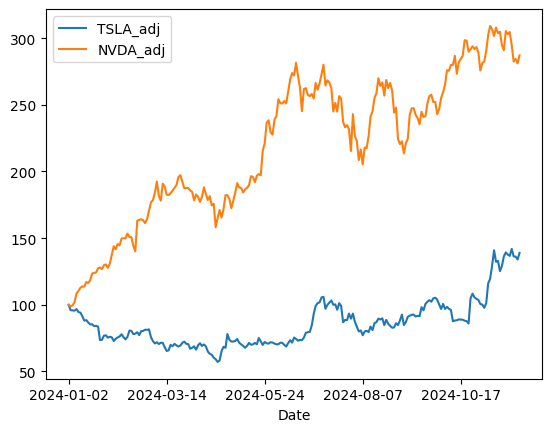

In [12]:
# chart로 그리기
result_df.loc['2024-01':'2024-12',['TSLA_adj','NVDA_adj']].plot()